# **SMM Assignment2**

在這份作業中，我們會使用Pytorch Geometric(PyG)來建構GCN模型，並將其應用到兩個OGB（Open Graph Benchmark）公開資料集上。一個資料集的任務是Node分類，另一個是圖分類。

首先，我們需要Pytorch Geometric將Graph資料存儲為Pytorch Tensor。

***請勿參考網路上的相關實作，也不能copy同學的code。**但你可以與同學或TA討論你遇到的問題。

In this assignment, we will use Pytorch Geometric (PyG) to construct the GCN model and apply it to two OGB (Open Graph Benchmark) public datasets. One dataset will be tasked with Node classification and the other with graph classification.

First, we need the Pytorch Geometric to store the Graph data as a Pytorch Tensor.

*Please do not refer to the related work on the web. But You can discuss your problems with your classmates or TA.


# 設備 Device

如果你使用Colab，請調整至GPU模式。

If you are using Colab, please adjust to GPU mode

# 安裝 Installation

In [2]:
import torch
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import pandas as pd
import random
print("PyTorch has version {}".format(torch.__version__))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

PyTorch has version 1.8.1+cu101


In [2]:
random_seed = 12
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

In [3]:
node_info = pd.read_csv('./node_info.csv')
y = node_info['fraud_risk']
x = node_info.drop(columns=['user_id', 'fraud_risk'])
edge_index = pd.read_csv('edge_index.csv')
feature_num = len(x.iloc[0])
feat1 = x.iloc[:, 0:5].max().max() + 1
feat2 = x.iloc[:, 5:10].max().max() + 1
feat3 = x.iloc[:, 10:15].max().max() + 1

In [5]:
y.value_counts()

0    33280
1      452
Name: fraud_risk, dtype: int64

In [4]:
idx = [i for i in range(len(y))]
train_idx, test_idx, _, _ = train_test_split(idx, idx, test_size=0.2, random_state=random_seed)
valid_idx, test_idx, _, _ = train_test_split(test_idx, test_idx, test_size=0.5, random_state=random_seed)

In [5]:
x = torch.tensor(x.values, dtype=torch.int32)
mask = (x != -1)
x = x * mask
edge_index = torch.tensor(edge_index.values.T, dtype=torch.long)
y = torch.tensor(y.values, dtype=torch.float32)
data = Data(x=x, edge_index=edge_index, y=y)

In [6]:
import torch
import torch.nn.functional as F

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator


## Load and Preprocess the Dataset

## GCN Model (10分)

實作GCN模型，請按照下圖所示的結構初始化所需要的layer，並實作`forwad`。BN為Batch Normalization。

Please follow the figure below to implement your `forward` function. BN is Batch 


![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = {
    'device': device,
    'num_layers': 3,
    'embedding_dim': 5,
    'hidden_dim': 64,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
    'output_feature': 1,
    'feat1': feat1,
    'feat2': feat2,
    'feat3': feat3
}

In [8]:
from torch_geometric.nn.conv import GCNConv
import torch.nn as nn
class GCN(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim, feat1, feat2, feat3, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):

        super(GCN, self).__init__()
        self.embeddings = nn.ModuleList()
        self.embeddings.append(nn.Embedding(feat1, embedding_dim))
        self.embeddings.append(nn.Embedding(feat2, embedding_dim))
        self.embeddings.append(nn.Embedding(feat3, embedding_dim))

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(GCNConv(input_dim * embedding_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))
        for i in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = dropout
        self.Sigmoid = nn.Sigmoid()
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        out = None
        sample = len(x)
        card = self.embeddings[0](x[:, :5])
        ip = self.embeddings[1](x[:, 5:10])
        device = self.embeddings[2](x[:, 10:15])
        # [33532, 1500] int32 type
        x = torch.cat([card, ip, device], dim=1).reshape(sample, -1)
        # float32 type, in GPU
        x = x.to(torch.float32).to(device)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            if self.training == True:
                x = F.dropout(x, p=self.dropout)
        x = self.convs[-1](x, adj_t)
        x = self.Sigmoid(x) if args['output_feature'] == 1 else self.softmax(x)
        out = x

        return out

In [9]:
model = GCN(feature_num, args['embedding_dim'], args['feat1'], args['feat2']
            , args['feat3'],args['hidden_dim'],
            args['output_feature'], args['num_layers'],
            args['dropout']).to(device)

In [10]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    loss = 0

    optimizer.zero_grad()
    x, edge_index = data['x'].to(device), data['edge_index'].to(device)
    output = model(x, edge_index)
    output = output[train_idx]
    label = torch.squeeze(data.y[train_idx]).to(device)
    if loss_fn == torch.nn.BCELoss:
        output = torch.squeeze(output)
        output = output.float()
        loss = loss_fn()(output, label)
    elif loss_fn == F.nll_loss:
        label = label.long()
        loss = loss_fn(output, label)


    loss.backward()
    optimizer.step()

    return loss.item()

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

In [12]:
@torch.no_grad()
def eval_nll(model, data, idx):
    model.eval()

    out = None
    threshold = 0.1
    ############# CODE HERE ############
    ## 1. 完成out的運算即可，記得將輸入資料轉移至device上
    ## 1. Just get output using model and remember to transfer the input data to the device
    x, edge_index = data['x'].to(device), data['edge_index'].to(device)
    output = model(x, edge_index)
    output = output[idx].cpu()
    output = output.argmax(dim=-1, keepdim=True)

    #########################################
    label = data['y'][idx]

    return accuracy_score(output, label), precision_score(output, label, zero_division=0), recall_score(output, label, zero_division=0), f1_score(output, label, zero_division=0)

In [13]:
@torch.no_grad()
def eval_bce(model, data, idx):
    model.eval()

    out = None
    threshold = 0.1
    ############# CODE HERE ############
    ## 1. 完成out的運算即可，記得將輸入資料轉移至device上
    ## 1. Just get output using model and remember to transfer the input data to the device
    x, edge_index = data['x'].to(device), data['edge_index'].to(device)
    output = model(x, edge_index)
    output = torch.squeeze(output)
    output = output.float()
    output = output[idx].cpu()
    output = torch.tensor([0 if x < threshold else 1 for x in output])
    #########################################
    label = data['y'][idx]
    count = sum(1 for label, output in zip(label, output) if label == 1 and output == 1)
    true = sum(label[i]==1 for i in range(len(label))).item()
    tp = count / true
    return accuracy_score(output, label), precision_score(output, label, zero_division=0), recall_score(output, label, zero_division=0), f1_score(output, label, zero_division=0), tp

In [14]:
import copy
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCELoss if args['output_feature'] == 1 else F.nll_loss
model.reset_parameters()
eval_func = eval_nll if loss_fn == F.nll_loss else eval_bce

best_model = None
best_f1 = 0
best_tp = 0
for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, data, train_idx, optimizer, loss_fn)
    if epoch % 10 == 0:
        valid_acc, precision, recall, f1, tp= eval_func(model, data, valid_idx)
        print(f'epoch:{epoch} loss: {loss} accuracy:', valid_acc, precision, recall, f1, tp)
        # if f1 > best_f1:
        #     best_f1 = f1
        #     best_model = copy.deepcopy(model)
        if (valid_acc > 0.9 and tp >= best_tp):
            best_tp = tp
            best_model = copy.deepcopy(model)
    else:
        # print(f'epoch:{epoch} loss: {loss}')
        pass

epoch:10 loss: 0.19202424585819244 accuracy: 0.019270678920841982 1.0 0.014008941877794338 0.027630805408583186 1.0
epoch:20 loss: 0.09993409365415573 accuracy: 0.44233619922917283 0.6595744680851063 0.016350210970464137 0.0319094184251158 0.6595744680851063
epoch:30 loss: 0.08226452022790909 accuracy: 0.8084790987251704 0.5319148936170213 0.03852080123266564 0.07183908045977011 0.5319148936170213
epoch:40 loss: 0.07410058379173279 accuracy: 0.8559146160687815 0.5319148936170213 0.05112474437627812 0.09328358208955224 0.5319148936170213
epoch:50 loss: 0.0641479417681694 accuracy: 0.9187666765490661 0.5957446808510638 0.0989399293286219 0.16969696969696968 0.5957446808510638
epoch:60 loss: 0.05863707512617111 accuracy: 0.9350726356359325 0.5957446808510638 0.12280701754385964 0.20363636363636364 0.5957446808510638
epoch:70 loss: 0.050909921526908875 accuracy: 0.9380373554699081 0.5957446808510638 0.12844036697247707 0.21132075471698114 0.5957446808510638
epoch:80 loss: 0.043633799999952

In [15]:
best_model.eval()
best_threshold = 0
best_tp = 0
i = 0.001
best_recall = 0
f1 = 0
while i <= 0.2:
    # The output of model on all data
    out = None
    # threshold = 0.02
    threshold = i
    ############# CODE HERE ############
    ## 1. 完成out的運算即可，記得將輸入資料轉移至device上
    ## 1. Just get output using model and remember to transfer the input data to the device
    x, test_edge_index = data['x'].to(device), data['edge_index'].to(device)
    output = best_model(x, test_edge_index)
    output = torch.squeeze(output)
    output = output.float()
    output = output[test_idx].cpu()
    output = torch.tensor([0 if x < threshold else 1 for x in output])
    #########################################
    label = data['y'][test_idx]
    count = sum(1 for label, output in zip(label, output) if label == 1 and output == 1)
    true = sum(label[i]==1 for i in range(len(label))).item()
    tp = count / true
    acc = accuracy_score(output, label)
    # acc, recall, f1 = accuracy_score(output, label), recall_score(output, label, zero_division=0), f1_score(output, label, zero_division=0)
    # _, _,recall, _ =accuracy_score(output, label), precision_score(output, label, zero_division=0), recall_score(output, label, zero_division=0), f1_score(output, label, zero_division=0)
    if(acc > 0.95 and tp >= best_tp):
        best_threshold = threshold
        best_tp = tp
    # print(recall)
    # if(acc > 0.9 and recall > best_recall):
    #     best_threshold = threshold
    #     best_recall = recall
    i += 0.01
    # disp = ConfusionMatrixDisplay.from_predictions(label, output, cmap='Greys',normalize='true', colorbar=False)

In [16]:
print(best_threshold)

0.07100000000000001


0.7105263157894737 recall: 0.14917127071823205 acc: 0.9510966212211025 pre: 0.7105263157894737 f1: 0.24657534246575344


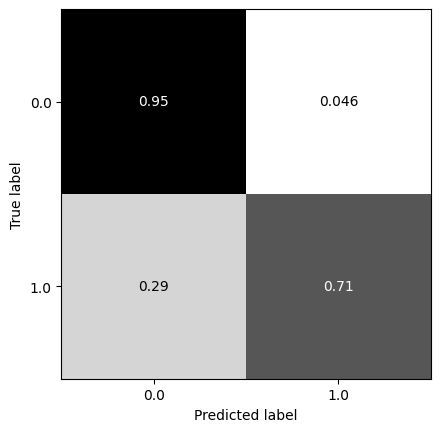

In [19]:
best_model.eval()

# The output of model on all data
out = None
# threshold = 0.02
threshold = best_threshold
############# CODE HERE ############
## 1. 完成out的運算即可，記得將輸入資料轉移至device上
## 1. Just get output using model and remember to transfer the input data to the device
x, test_edge_index = data['x'].to(device), data['edge_index'].to(device)
output = best_model(x, test_edge_index)
output = torch.squeeze(output)
output = output.float()
output = output[test_idx].cpu()
output = torch.tensor([0 if x < threshold else 1 for x in output])
#########################################
label = data['y'][test_idx]
count = sum(1 for label, output in zip(label, output) if label == 1 and output == 1)
true = sum(label[i]==1 for i in range(len(label))).item()
tp = count / true
print(tp, 'recall:', recall_score(output, label, zero_division=0), 'acc:', accuracy_score(output, label), 'pre:', precision_score(output, label, zero_division=0), 'f1:', f1_score(output, label, zero_division=0))
disp = ConfusionMatrixDisplay.from_predictions(label, output, cmap='Greys',normalize='true', colorbar=False)

In [20]:
print('recall:', recall_score(label, output, zero_division=0), 'acc:', accuracy_score(label, output), 'pre:', precision_score(label, output, zero_division=0), 'f1:', f1_score(label, output, zero_division=0))

recall: 0.7105263157894737 acc: 0.9510966212211025 pre: 0.14917127071823205 f1: 0.24657534246575344


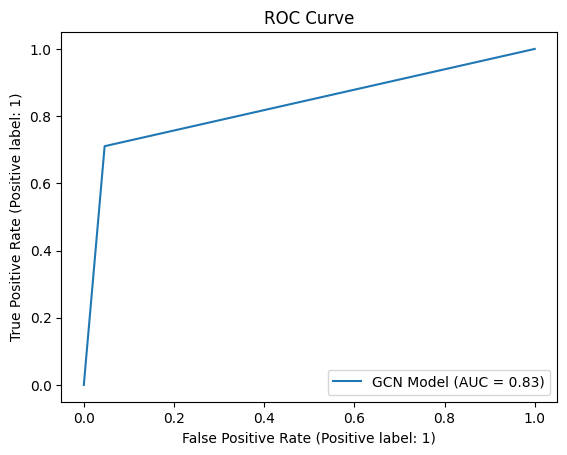

In [18]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(label, output, name="GCN Model")
_ = display.ax_.set_title("ROC Curve")

# Appendix

In [ ]:
import copy

model.reset_parameters()

loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0


# build model
scheduler, opt = build_optimizer(args, model.parameters())

# train
losses = []
test_accs = []
for epoch in range(args.epochs):
    total_loss = 0
    model.train()
    for batch in train_dataloader:
        opt.zero_grad()
        pred = model(batch)
        label = batch.y
        pred = pred[batch.train_mask]
        label = label[batch.train_mask]
        loss = model.loss(pred, label)
        loss.backward()
        opt.step()
        total_loss += loss.item() * batch.num_graphs
    total_loss /= len(train_dataloader.dataset)
    #print("Loss:{}".format(total_loss))
    losses.append(total_loss)

    # if epoch % 10 == 0:
    #   test_acc = test(train_dataloader, model)
    #   #print("Test acc:{}".format(test_acc))
    #   test_accs.append(test_acc)
    # else:
    #   test_accs.append(test_accs[-1])

In [ ]:
best_result = test(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Load and preprocess the dataset

In [ ]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

# Load the dataset 
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

split_idx = dataset.get_idx_split()

# Check task type
print('Task type: {}'.format(dataset.task_type))

In [ ]:
# Load the data sets into dataloader
# 每個Batch 32張Graph，training需打亂順序
# We will train the graph classification task on a batch of 32 graphs
# Shuffle the order of graphs for training set
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

In [ ]:
# 注意，請勿改變此處參數！
# Don't change!
args = {
    'device': device,
    'num_layers': 5,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 30,
}
args

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train.values, dtype=torch.float32)
edge_index = torch.tensor(edge_index.values.T, dtype=torch.long)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
train_data = Data(x=x_train, edge_index=edge_index, y=y_train)

In [ ]:
from torch.utils.data import Dataset
class FraudDataset(Dataset):
    def __init__(self, data):
        super(FraudDataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data.y)

    def __getitem__(self, idx):
        x = self.data.x[idx]
        y = self.data.y[idx]
        edge_index = self.data.edge_index
        return {'x': x, 'y': y, 'edge_index': edge_index}
dataset = FraudDataset(train_data)
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
from torch_geometric.data import Data
class FraudDetect(Data):
    def __init__(self, x, edge_index, y):
        super(FraudDetect, self).__init__()
        # self.x = x  # Node feature matrix
        # self.edge_index = edge_index  # Graph connectivity
        # self.y = y # Target variable for fraud detection
        self.length = len(y)
        self.x = torch.tensor(x.values, dtype=torch.float32)
        # print(self.x.shape)
        self.edge_index = torch.tensor(edge_index.values.T, dtype=torch.long)
        # print(self.edge_index.shape)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        # print(self.y.shape)
    def __getitem__(self, idx):
        # data = super().__getitem__(idx)
        # x = data.x
        # edge_index = data.edge_index
        # y = data.y
        # data = super().__getitem__(idx)
        # x = self.x.iloc[idx]
        # edge_index = self.edge_index.iloc[idx]
        # y = self.y.iloc[idx]
        return {'x': self.x[idx], 'y': self.y[idx], 'edge_index': self.edge_index[idx]}
    def __len__(self):
        return (self.length)
x_train = torch.tensor(x_train.values, dtype=torch.float32)
edge_index = torch.tensor(edge_index.values.T, dtype=torch.long)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
from torch_geometric.loader import DataLoader
train_data = FraudDetect(x_train, edge_index, y_train)
test_data = FraudDetect(x_test, edge_index, y_test)
# train_data = [FraudDetect(x_train, edge_index, y_train)]
# test_data = [FraudDetect(x_test, edge_index, y_test)]
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=lambda x: x)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=lambda x: x)

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
import os

class FraudDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super(FraudDataset, self).__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['FraudDataset.dataset']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []
        print(os.getcwd())
        node_info = pd.read_csv('./node_info.csv')
        y = node_info['fraud_risk']
        x = node_info.drop(columns=['user_id', 'fraud_risk'])
        edge_index = pd.read_csv('./edge_index.csv')
        
        x = torch.tensor(x.values, dtype=torch.float32)
        edge_index = torch.tensor(edge_index.values.T, dtype=torch.long)
        y = torch.tensor(y.values, dtype=torch.float32)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
dataset = FraudDataset(root='data/')
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)